# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


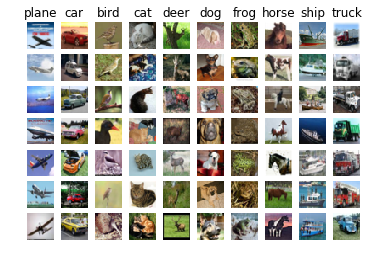

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
# 用这部分来优化代码
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


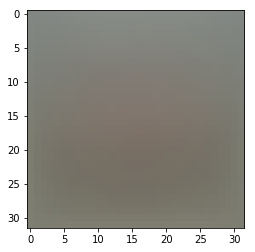

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time
import numpy as np

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.101400


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [74]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -0.648353 analytic: -0.648353, relative error: 1.182198e-10
numerical: 7.519127 analytic: 7.519127, relative error: 2.983882e-11
numerical: 2.113882 analytic: 2.113882, relative error: 3.455298e-11
numerical: -40.000593 analytic: -40.000593, relative error: 1.193339e-12
numerical: 11.158993 analytic: 11.158993, relative error: 1.192527e-11
numerical: -12.849167 analytic: -12.849167, relative error: 1.123947e-13
numerical: -20.680566 analytic: -20.680566, relative error: 2.316158e-12
numerical: 7.710460 analytic: 7.710460, relative error: 1.648619e-11
numerical: -11.317083 analytic: -11.317083, relative error: 7.942691e-12
numerical: 15.845878 analytic: 15.845878, relative error: 1.461790e-11
numerical: -7.313609 analytic: -7.313609, relative error: 5.455916e-11
numerical: 37.380208 analytic: 37.380208, relative error: 1.427854e-11
numerical: -15.238118 analytic: -15.238118, relative error: 9.006857e-12
numerical: 1.890998 analytic: 1.890998, relative error: 1.076526e-10
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [73]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.101400e+00 computed in 0.123196s
Vectorized loss: 9.101400e+00 computed in 0.003521s
difference: 0.000000


In [75]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.101824s
Vectorized loss and gradient: computed in 0.003600s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [58]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 398.305524
iteration 100 / 1500: loss 146.937190
iteration 200 / 1500: loss 56.821147
iteration 300 / 1500: loss 24.106739
iteration 400 / 1500: loss 12.278265
iteration 500 / 1500: loss 7.442766
iteration 600 / 1500: loss 5.520341
iteration 700 / 1500: loss 6.085227
iteration 800 / 1500: loss 5.037201
iteration 900 / 1500: loss 5.057929
iteration 1000 / 1500: loss 4.482786
iteration 1100 / 1500: loss 5.091226
iteration 1200 / 1500: loss 4.955007
iteration 1300 / 1500: loss 4.790725
iteration 1400 / 1500: loss 4.692104
That took 2.192419s


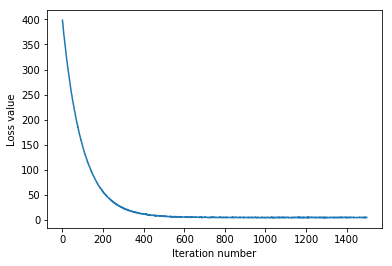

In [59]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [68]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369694
validation accuracy: 0.371000


In [78]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# 随机了一个50x2尺寸的，给这50张图各随机了两个hypers
rand_turple = np.random.rand(50,2)
rand_turple[:,0] = rand_turple[:,0]*(learning_rates[1]-learning_rates[0]) + learning_rates[0]
rand_turple[:,1] = rand_turple[:,1]*(regularization_strengths[1]-regularization_strengths[0])+regularization_strengths[0]
for lr,rs in rand_turple:
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=lr, reg=rs,num_iters=1500, verbose=True)
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_train)
    val_acc = np.mean(y_train == y_val_pred)
    results[(lr,rs)] = (train_acc,val_acc)
    if (val_acc > best_val):
        best_val = val_acc
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 787.683835
iteration 100 / 1500: loss 3056104280043289427735814287731676579636010992728334391301926772486272964739155194995831148974899724019564544.000000
iteration 200 / 1500: loss 11148535455101452192859714805648227316538245859781369544681962712705985201970691742710998700311412643844141167372541105663332214960157293562074638620301334389861453893579415593504140064984374673477857982758403440640.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 744.076584
iteration 100 / 1500: loss 569.076792
iteration 200 / 1500: loss 604.180449
iteration 300 / 1500: loss 622.894044
iteration 400 / 1500: loss 480.778049
itera

iteration 500 / 1500: loss 17.185377
iteration 600 / 1500: loss 27.736083
iteration 700 / 1500: loss 20.439835
iteration 800 / 1500: loss 23.596837
iteration 900 / 1500: loss 26.199042
iteration 1000 / 1500: loss 23.410040
iteration 1100 / 1500: loss 15.930365
iteration 1200 / 1500: loss 18.104962
iteration 1300 / 1500: loss 22.663947
iteration 1400 / 1500: loss 17.503282
iteration 0 / 1500: loss 582.108407
iteration 100 / 1500: loss 225863143984941021564990502637521611038260159881036003219132202519401407839945621504.000000
iteration 200 / 1500: loss 75265512987783733419051643363277898283210895685412570546130398001685406676501491108142155909021694932226120842085071670161114691237005314454803534822798026837327872.000000
iteration 300 / 1500: loss 2508110595366517569684394481269564972328879468073274915145575765525696354085308473706126182799809019138997422135873307790311614904222707602285163749799592517492336739382653164705604432577040114116001830979168181852972481163551140054159872072089

iteration 400 / 1500: loss 2354929373989941008993793105786930270016701532102635543470442072605110212159481781763363930019685317312372902939468115214336.000000
iteration 500 / 1500: loss 2742304242950313255878899764005277160311307053515151492501917669723650826094302729046360575727594123451280692777468210288506675034993232389907860642856960.000000
iteration 600 / 1500: loss 3193400466257642038669557542169891649613331029156015564208398092779934587307295295914592616622910330831238578264930234138704352527188812359605305886589784010597732556839798427269201920.000000
iteration 700 / 1500: loss 3718699908702760099504819877775479938281310565870131976583734162329159553120635646021102026870840678118862887770632433880229527928185452310606223905056734944808335032286741286764754761440225709203076536399650881536.000000
iteration 800 / 1500: loss 4330408652815116335051230553521881424456995626458349716369625912271929037955388638298765927054330835266220481723571961602989917480022688726472169364571489010

iteration 200 / 1500: loss 54613538136918664121671963262130978248068190409053045296277330116842352541696.000000
iteration 300 / 1500: loss 388328935494233645281298681503867465214541306636823278026719061640603758183791261766731020355076341320011806146560.000000
iteration 400 / 1500: loss 2761208434509841203028474963709215888280655938211622323525112039666677729486572103620456772315046119834565503810252543081229214103798587660563600375808.000000
iteration 500 / 1500: loss 19633540851404058808572007664430658108182162245727128547227373538869985207872478736554502437530111154152594461513637140979031935965863240559340540876150442396498440018781047252721852219392.000000
iteration 600 / 1500: loss 139604066663725172527564869053377542373188822243673282387848890802447272171529950063202965254692721663262732095801740793334684283752683758729932623093140456597863943204719021844386017811869932018483947655745288551727611510784.000000
iteration 700 / 1500: loss 9926531121693250066705857159677316256873880

iteration 400 / 1500: loss 20.252669
iteration 500 / 1500: loss 20.414738
iteration 600 / 1500: loss 26.240377
iteration 700 / 1500: loss 21.039038
iteration 800 / 1500: loss 26.855870
iteration 900 / 1500: loss 27.158683
iteration 1000 / 1500: loss 18.754690
iteration 1100 / 1500: loss 29.048321
iteration 1200 / 1500: loss 37.961347
iteration 1300 / 1500: loss 23.110694
iteration 1400 / 1500: loss 29.521695
iteration 0 / 1500: loss 697.335843
iteration 100 / 1500: loss 8955683198680667948042875934169056303472184548091381149286779190112719447037592968626176.000000
iteration 200 / 1500: loss 101710906477705313548905314965728053220344069336017033338587276477080480665559204794776632941265967827069280811518377992378706526213698686512812715277236172518728438107865088.000000
iteration 300 / 1500: loss 1155144534147940259661468777890818157567503292906331072554470565039579757270702750637067769228249859767666709451943542565937535920867581483960381271943303841586516037714004700607696549568640344

iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 441.509218
iteration 100 / 1500: loss 647977940983046025952539398723600384.000000
iteration 200 / 1500: loss 297117388740828658413950080596246348346429898095463121818692588929024.000000
iteration 300 / 1500: loss 136237265358510882719926536666467892064886939177606172310772676701328840688149772137695437702349979648.000000
iteration 400 / 1500: loss 62468886627687232872223393567660412938403567020018224039609955723483052323296781463338595458374725988152886130417453100350590024679424.000000
iteration 500 / 1500: loss 28643864703491406600561080430274591485231597371361279133796554842251100575841210525543360161426929120614552751739802401390851109602934922325747240610745459454479695872.000000
iteration 600 / 1500: loss 1313407408782397609521036249541139804146389562106878071416735392950525408431939667950247257178352502314508728694226015778100044213299298086443147392962367388315286252806523391552509441551148

iteration 1400 / 1500: loss 4401013513817026795753931197814803051522919830615290382814615041456673792167084770804857886585429102235864267155832832.000000
iteration 0 / 1500: loss 416.788388
iteration 100 / 1500: loss 164.005189
iteration 200 / 1500: loss 153.147512
iteration 300 / 1500: loss 174.678875
iteration 400 / 1500: loss 152.026374
iteration 500 / 1500: loss 161.427938
iteration 600 / 1500: loss 122.494570
iteration 700 / 1500: loss 193.689380
iteration 800 / 1500: loss 169.213195
iteration 900 / 1500: loss 101.779712
iteration 1000 / 1500: loss 174.382408
iteration 1100 / 1500: loss 161.116325
iteration 1200 / 1500: loss 177.767716
iteration 1300 / 1500: loss 145.739014
iteration 1400 / 1500: loss 172.827797
iteration 0 / 1500: loss 568.771084
iteration 100 / 1500: loss 18.546034
iteration 200 / 1500: loss 23.294030
iteration 300 / 1500: loss 24.818739
iteration 400 / 1500: loss 14.775540
iteration 500 / 1500: loss 19.448602
iteration 600 / 1500: loss 16.789540
iteration 700 /

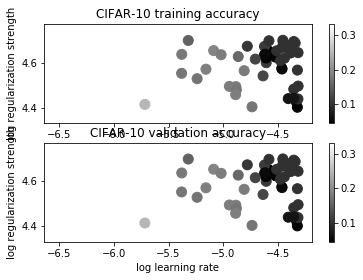

In [79]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [80]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.341000


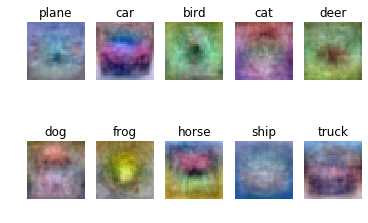

In [81]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*